In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML
from sklearn.preprocessing import LabelEncoder

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor 
# from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge

In [3]:
data = pd.read_excel("aydin_house_price.xlsx")
df = data.copy()

In [4]:
def getting_primary_info(df):
    print("------------------------------------------------------")
    print("Veri setinin şekli", df.shape)
    print("------------------------------------------------------")
    print("Veri seti değişken tipleri:", df.dtypes)
    print("------------------------------------------------------")
    print("Veri setinin ilk 5 satırı")
    display(HTML(df.head().to_html()))
    print("------------------------------------------------------")
    print("Veri setinin istatistiki verileri")
    description = df.describe()
    display(HTML(description.to_html()))
    print("------------------------------------------------------")  
getting_primary_info(df)

------------------------------------------------------
Veri setinin şekli (3399, 24)
------------------------------------------------------
Veri seti değişken tipleri: Ay                                int64
Dolar                           float64
Euro                            float64
Altın                           float64
Petrol                          float64
Beton                             int64
Demir                           float64
Fiyat                            object
Son Güncelleme Tarihi    datetime64[ns]
Konut Tipi                       object
Mahalle                          object
 Net M2                         float64
Oda                             float64
 Salon Sayısı                   float64
Bulunduğu Kat                    object
Bina Yaşı                        object
Isınma Tipi                      object
Eşya Durumu                      object
Banyo Sayısı                      int64
Cephe                            object
Kira Getirisi                   

,Ay,Dolar,Euro,Altın,Petrol,Beton,Demir,Fiyat,Son Güncelleme Tarihi,Konut Tipi,Mahalle,Net M2,Oda,Salon Sayısı,Bulunduğu Kat,Bina Yaşı,Isınma Tipi,Eşya Durumu,Banyo Sayısı,Cephe,Kira Getirisi,Kullanım Durumu,Aidat,Yakıt Tipi
0,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,1.950.000 TL,2023-12-12,Daire,Cumhuriyet,85.0,2.0,1.0,3. Kat,5 Yaşında,Kombi,Eşyalı Değil,1,NaN,NaN,Boş,NaN,Doğalgaz
1,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,1.800.000 TL,2023-10-10,Daire,Cumhuriyet,140.0,3.0,1.0,Ara Kat,25 Yaşında,Kombi,Eşyalı Değil,1,"Kuzey, Batı",NaN,NaN,NaN,Doğalgaz
2,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,2.875.000 TL,2023-12-26,Daire,Mimar Sinan,125.0,3.0,1.0,En Üst Kat,9 Yaşında,Kombi,Eşyalı Değil,1,"Kuzey, Güney, Batı",8.000 TL,Mülk Sahibi,100 TL,Doğalgaz
3,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,1.850.000 TL,2023-12-26,Daire,Meşrutiyet,120.0,3.0,1.0,3. Kat,35 Yaşında,Isıtma Yok,Eşyalı Değil,1,NaN,NaN,Boş,30 TL,NaN
4,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,2.000.000 TL,2023-12-26,Daire,Cumhuriyet,90.0,2.0,1.0,2. Kat,22 Yaşında,Kombi,Eşyalı Değil,1,"Kuzey, Güney, Doğu",NaN,Kiracılı,NaN,Doğalgaz


------------------------------------------------------
Veri setinin istatistiki verileri


,Ay,Dolar,Euro,Altın,Petrol,Beton,Demir,Son Güncelleme Tarihi,Net M2,Oda,Salon Sayısı,Banyo Sayısı
count,3399.000000,3399.000000,3399.000000,3399.000000,3399.000000,3399.000000,3399.000000,3399,3201.000000,2113.000000,2113.000000,3399.000000
mean,2.000294,30.120077,33.059961,1987.084763,79.843869,2033.333333,22802.708088,2023-12-27 02:24:53.380406016,136.861918,2.792712,1.017037,1.392174
min,1.000000,29.395700,32.680100,1960.790000,78.760000,1900.000000,21939.810000,2023-09-28 00:00:00,22.000000,1.000000,0.000000,1.000000
25%,1.000000,29.395700,32.680100,1960.790000,78.760000,1900.000000,21939.810000,2023-12-04 00:00:00,85.000000,2.000000,1.000000,1.000000
50%,2.000000,29.840300,32.706100,1966.770000,80.190000,2100.000000,22829.170000,2023-12-25 00:00:00,120.000000,3.000000,1.000000,1.000000
75%,3.000000,31.123100,33.792700,2033.630000,80.580000,2100.000000,23638.430000,2024-01-17 12:00:00,150.000000,3.000000,1.000000,2.000000
max,3.000000,31.123100,33.792700,2033.630000,80.580000,2100.000000,23638.430000,2024-02-26 00:00:00,5330.000000,9.000000,6.000000,7.000000
std,0.816797,0.732654,0.518653,33.029421,0.782400,94.294776,693.965739,NaN,201.588851,1.129244,0.239739,0.741090


------------------------------------------------------


In [5]:
# PREPARE COLUMNS 
df['Fiyat'] = df['Fiyat'].str.replace('.', '').str.replace('TL', '').astype(int)

df['Eşya_durumu'] = df['Eşya Durumu'].apply(lambda x: 1 if x == 'Eşyalı' else 0)
df['Son Güncelleme Tarihi'] = pd.to_datetime(df['Son Güncelleme Tarihi'])

df = df.sort_values(by=['Son Güncelleme Tarihi', 'Ay'])

df.drop_duplicates(subset=['Son Güncelleme Tarihi', 'Mahalle' ,'Konut Tipi','Fiyat' ,'Bulunduğu Kat',' Net M2','Oda '], inplace=True)

df['Aidat'] = df['Aidat'].str.replace('.', '').str.replace('TL', '').astype(float)
df['Aidat_TL'] = df['Aidat'].apply(lambda x: 0 if pd.isna(x) else x)

df['Kira Getirisi_TL'] = df['Kira Getirisi'].str.replace('.', '').str.replace('TL', '').astype(float)
df['Kira Getirisi_TL'] = df['Kira Getirisi_TL'].apply(lambda x: 0 if pd.isna(x) else x)

df['Bina Yaşı'] = df['Bina Yaşı'].apply(lambda x: x.split()[0] if 'Yaşında' in x else x)
df['Bina Yaşı'] = df['Bina Yaşı'].replace('Sıfır Bina', 0)

df['Bina Yaşı'] = df['Bina Yaşı'].astype(float)

columns_ = ['Eşya Durumu', 'Kira Getirisi','Aidat'] 
df.drop(columns=columns_, inplace=True)

In [6]:
df.reset_index(drop=True, inplace=True)

In [7]:
df['Bulunduğu Kat'] = df['Bulunduğu Kat'].apply(lambda x: str(x).split('.')[0].strip() if '.' in str(x) else str(x).strip())
df['Bulunduğu Kat'] = df['Bulunduğu Kat'].apply(lambda x: x.split()[1].strip() if 'Kot' in x else x.strip())


df['Bulunduğu Kat'] = df['Bulunduğu Kat'].apply(lambda x: 0 if 'Zemin' in x or 'Bahçe' in x or "Yüksek" in x or "Giriş" in x else (2 if 'Ara Kat' in x else (-1 if 'Bodrum' in x else (3 if 'Teras' in x or 'Çatı Katı' in x or "En Üst Kat" in x else x))))
df['Bulunduğu Kat'] = df['Bulunduğu Kat'].apply(lambda x: '0' if x == "nan" else x)

df['Bulunduğu Kat'] = df['Bulunduğu Kat'].astype(float)

df["Kullanım Durumu"] = df["Kullanım Durumu"].fillna("Belirtilmemiş")

In [8]:
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    unique_values = df[column].unique()
    print(f"Unique values for column '{column}': {unique_values}")
    print("----------------------------------------------")

Unique values for column 'Konut Tipi': ['Daire' 'Residence' 'Çiftlik Evi' 'Villa' 'Müstakil Ev' 'Bina' 'Köy Evi'
 'Loft Daire' 'Prefabrik']
----------------------------------------------
Unique values for column 'Mahalle': ['Girne' 'Ata' 'Kurtuluş' 'Mesudiye' 'Efeler' 'Hasanefendi - Ramazan Paşa'
 'Meşrutiyet' 'Güzelhisar' 'Cuma' 'Adnan Menderes' 'Kemer' 'Baltaköy'
 'Umurlu' 'Zeybek' 'Kenger' 'Köprülü - Veysipaşa' 'Fatih' 'Yedi Eylül'
 'Orta' 'Zafer' 'Cumhuriyet' 'Dalama' 'Mimar Sinan' 'Ilıcabaşı' 'Serçeköy'
 'İmamköy' 'Karaköy' 'Şahnalı' 'Yılmazköy' 'Kuloğullar' 'Çeştepe'
 'Osman Yozgatlı' 'Kızılcaköy' 'Eğrikavak' 'Gödrenli' 'Kırıklar'
 'İstiklal' 'Gölcük' 'Işıklı' 'Kardeşköy' 'Gölhisar' 'Armutlu' 'Tepecik'
 'Ovaeymir' 'Musluca' 'Kocagür']
----------------------------------------------
Unique values for column 'Isınma Tipi': ['Merkezi (Pay Ölçer)' 'Merkezi' 'Kombi' 'Soba' 'Belirtilmemiş' 'Klima'
 'Yerden Isıtma' 'Kat Kaloriferi' 'Isıtma Yok' 'Doğalgaz Sobası'
 'Güneş Enerjisi' 'Isı Po

Scatter Plot for column 'Ay'


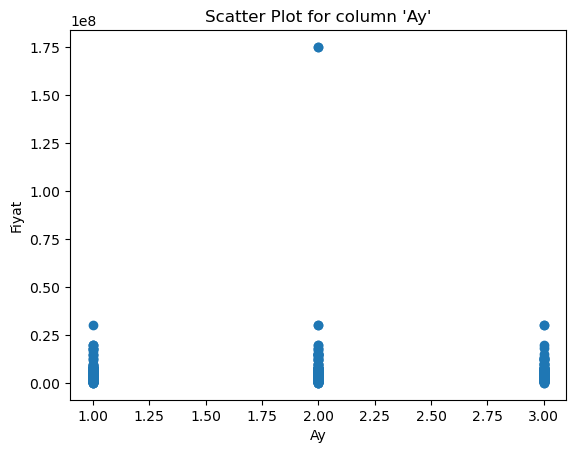

----------------------------------------------
Scatter Plot for column 'Dolar'


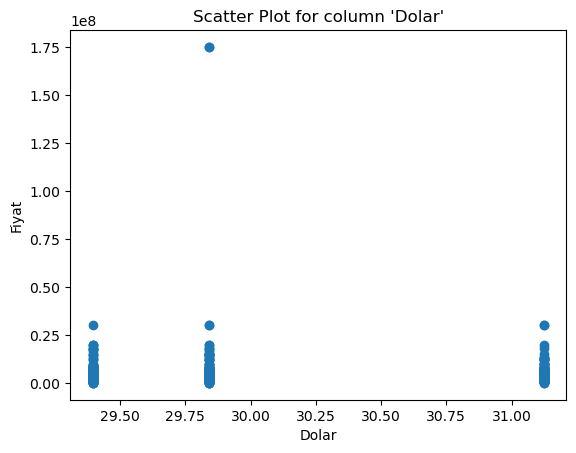

----------------------------------------------
Scatter Plot for column 'Euro'


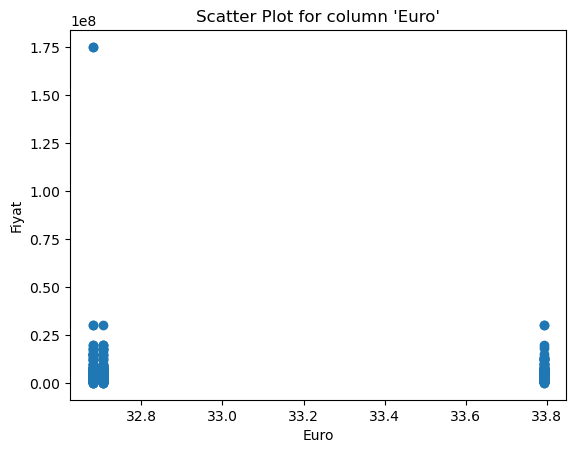

----------------------------------------------
Scatter Plot for column 'Altın'


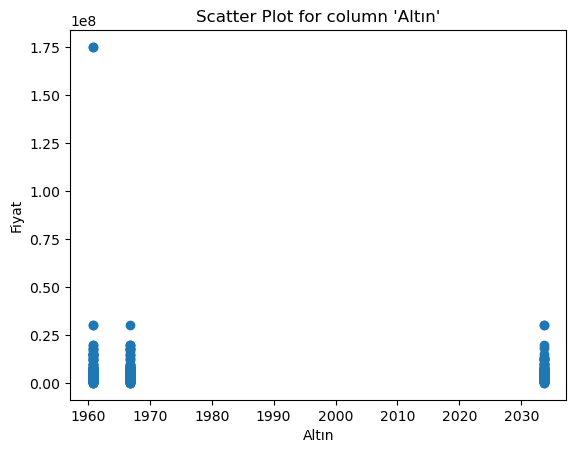

----------------------------------------------
Scatter Plot for column 'Petrol'


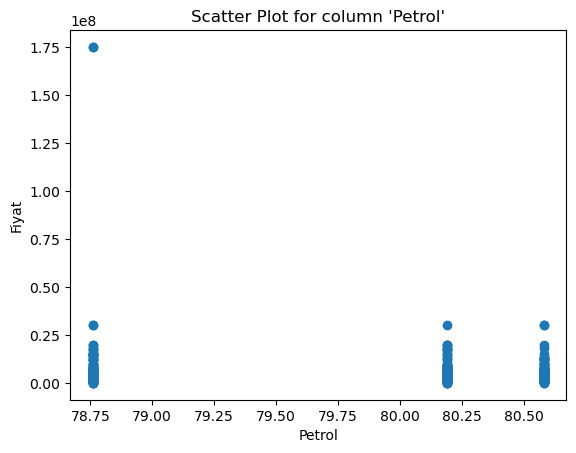

----------------------------------------------
Scatter Plot for column 'Beton'


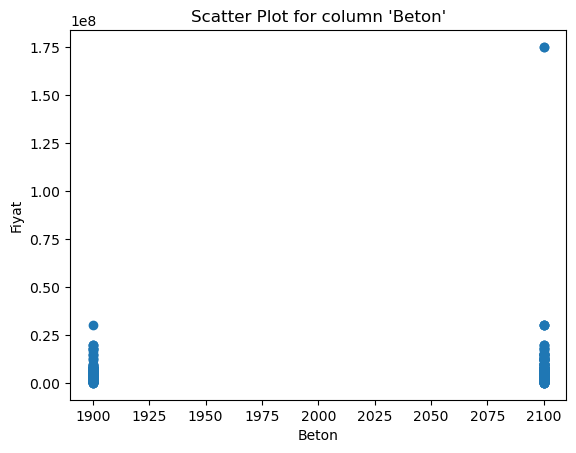

----------------------------------------------
Scatter Plot for column 'Demir'


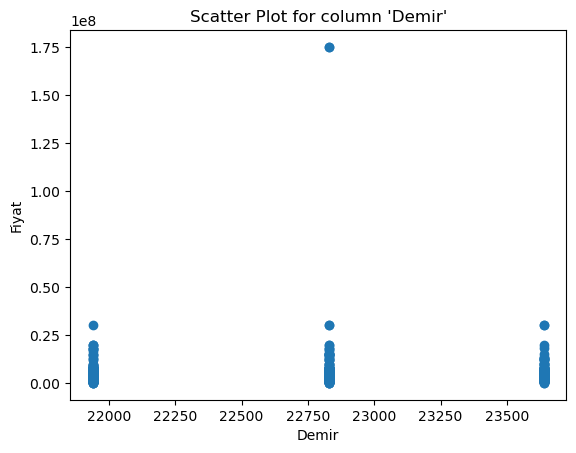

----------------------------------------------
Scatter Plot for column 'Fiyat'


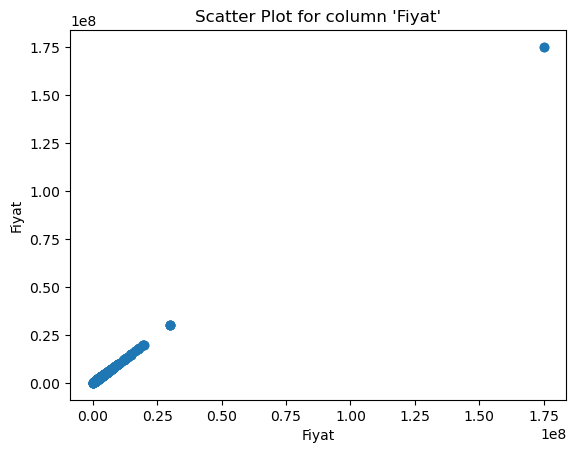

----------------------------------------------
Scatter Plot for column ' Net M2'


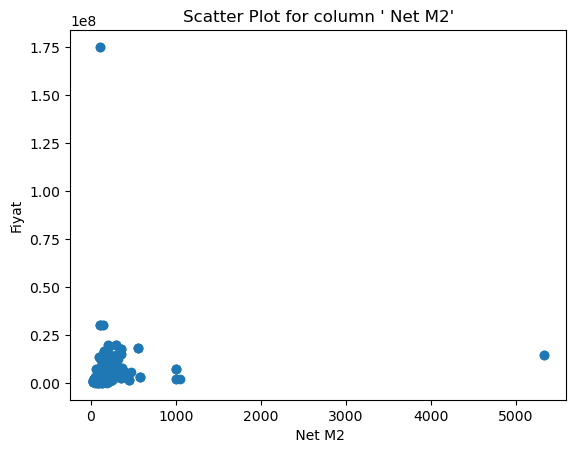

----------------------------------------------
Scatter Plot for column 'Oda '


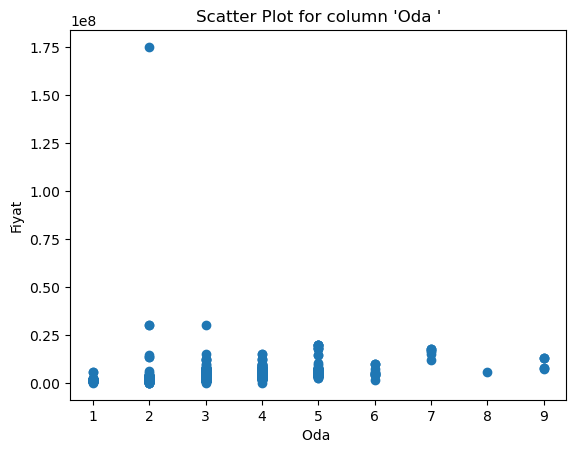

----------------------------------------------
Scatter Plot for column ' Salon Sayısı'


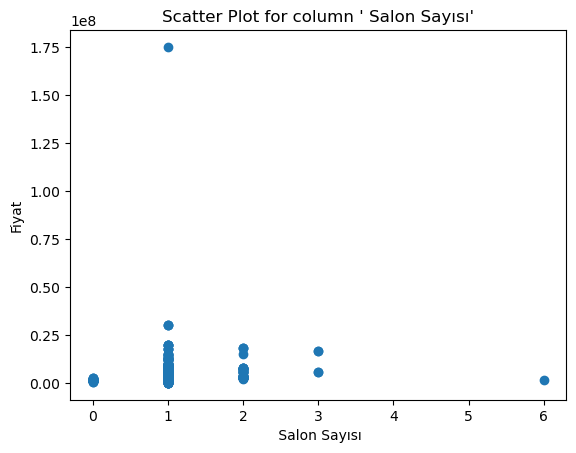

----------------------------------------------
Scatter Plot for column 'Bulunduğu Kat'


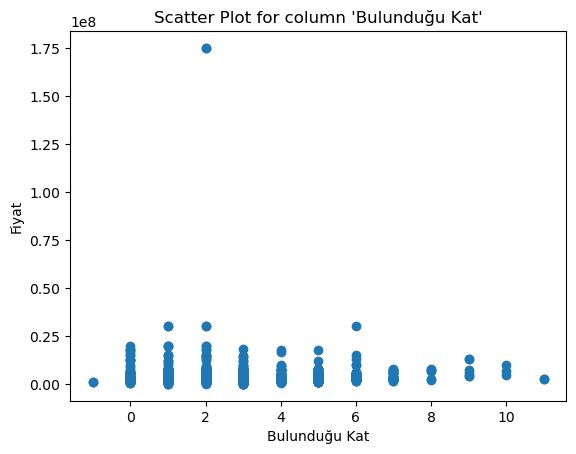

----------------------------------------------
Scatter Plot for column 'Bina Yaşı'


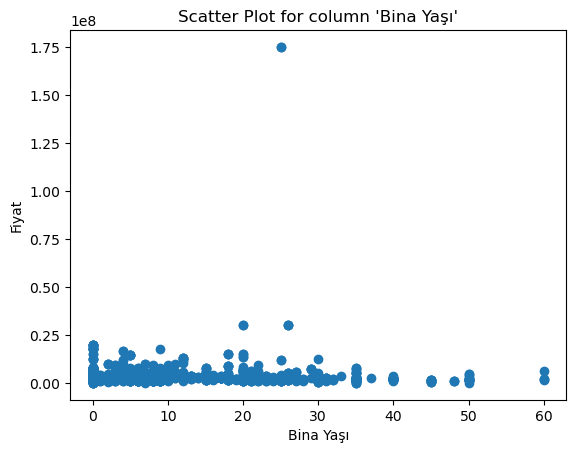

----------------------------------------------
Scatter Plot for column 'Banyo Sayısı'


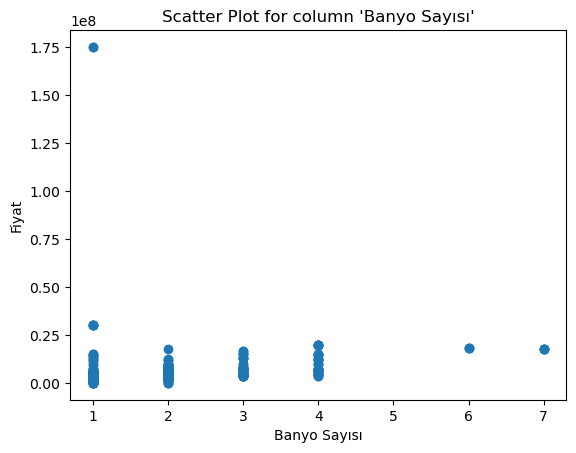

----------------------------------------------
Scatter Plot for column 'Eşya_durumu'


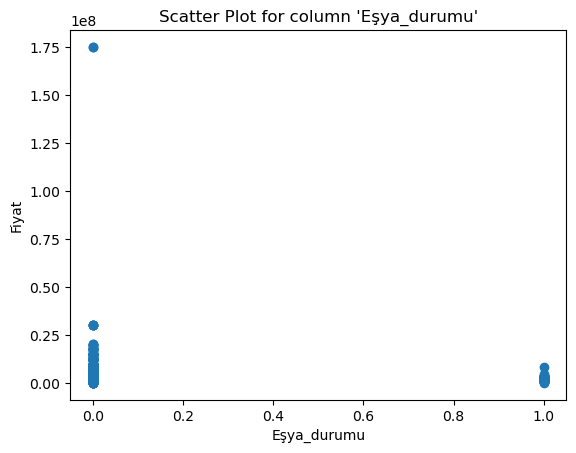

----------------------------------------------
Scatter Plot for column 'Aidat_TL'


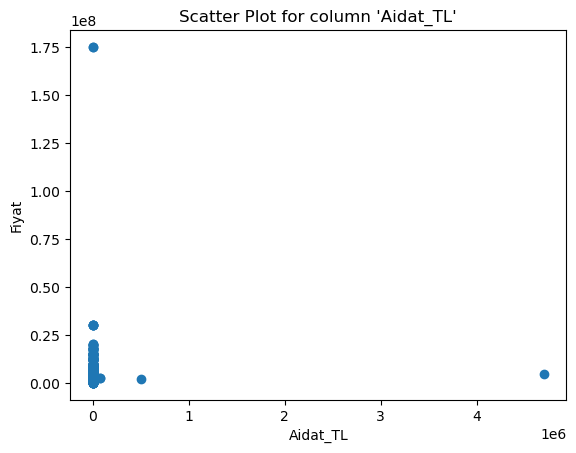

----------------------------------------------
Scatter Plot for column 'Kira Getirisi_TL'


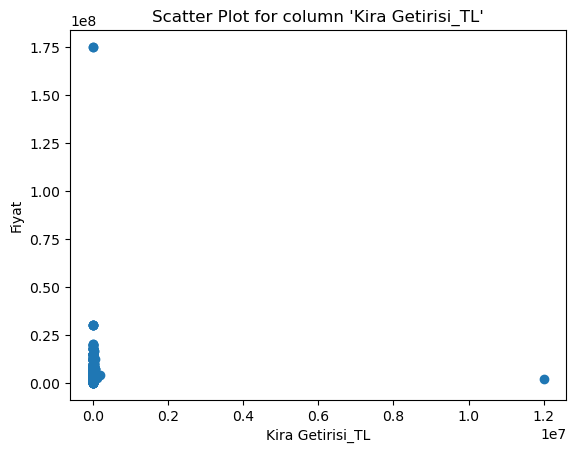

----------------------------------------------


In [9]:
num_cols = df.select_dtypes(include=['float64' , "int64","int32"]).columns

for column in num_cols:
    print(f"Scatter Plot for column '{column}'")
    plt.scatter(x = column , y = "Fiyat", data = df)
    plt.xlabel(column)
    plt.ylabel('Fiyat')
    plt.title(f"Scatter Plot for column '{column}'")
    plt.show()
    print("----------------------------------------------")

In [10]:
df.query("`Kira Getirisi_TL` == 0.0 & Fiyat > 150000000")
# Drop 1350

,Ay,Dolar,Euro,Altın,Petrol,Beton,Demir,Fiyat,Son Güncelleme Tarihi,Konut Tipi,...,Bulunduğu Kat,Bina Yaşı,Isınma Tipi,Banyo Sayısı,Cephe,Kullanım Durumu,Yakıt Tipi,Eşya_durumu,Aidat_TL,Kira Getirisi_TL
1350,2,29.8403,32.6801,1960.79,78.76,2100,22829.17,175000000,2024-01-05,Daire,...,2.0,25.0,Klima,1,NaN,Belirtilmemiş,NaN,0,0.0,0.0


In [11]:
df.query("`Kira Getirisi_TL` > 5200000")
# drop 338

,Ay,Dolar,Euro,Altın,Petrol,Beton,Demir,Fiyat,Son Güncelleme Tarihi,Konut Tipi,...,Bulunduğu Kat,Bina Yaşı,Isınma Tipi,Banyo Sayısı,Cephe,Kullanım Durumu,Yakıt Tipi,Eşya_durumu,Aidat_TL,Kira Getirisi_TL
338,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,1750000,2023-11-19,Daire,...,2.0,25.0,Kombi,1,"Doğu, Batı",Mülk Sahibi,Doğalgaz,0,150.0,12000000.0


In [12]:
df.query("`Aidat_TL` > 500000")
# drop 1855, 1863

,Ay,Dolar,Euro,Altın,Petrol,Beton,Demir,Fiyat,Son Güncelleme Tarihi,Konut Tipi,...,Bulunduğu Kat,Bina Yaşı,Isınma Tipi,Banyo Sayısı,Cephe,Kullanım Durumu,Yakıt Tipi,Eşya_durumu,Aidat_TL,Kira Getirisi_TL
1855,3,31.1231,33.7927,2033.63,80.58,2100,23638.43,2100000,2024-02-26,Daire,...,2.0,25.0,Klima,1,"Kuzey, Güney, Doğu, Batı",Boş,Elektrik,1,501580.0,18000.0
1863,3,31.1231,33.7927,2033.63,80.58,2100,23638.43,4700000,2024-02-26,Daire,...,0.0,7.0,Kombi,2,NaN,Belirtilmemiş,Doğalgaz,0,4700000.0,0.0


In [13]:
df.query("`Banyo Sayısı` > 5")
# drop 879,961,988,989,1232,1294,1751

,Ay,Dolar,Euro,Altın,Petrol,Beton,Demir,Fiyat,Son Güncelleme Tarihi,Konut Tipi,...,Bulunduğu Kat,Bina Yaşı,Isınma Tipi,Banyo Sayısı,Cephe,Kullanım Durumu,Yakıt Tipi,Eşya_durumu,Aidat_TL,Kira Getirisi_TL
879,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,18000000,2023-12-21,Villa,...,2.0,0.0,Kombi,6,"Kuzey, Güney, Doğu, Batı",Boş,Doğalgaz,0,0.0,0.0
961,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,17500000,2023-12-24,Villa,...,0.0,0.0,Kombi,7,NaN,Boş,Doğalgaz,0,0.0,0.0
988,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,17500000,2023-12-24,Villa,...,0.0,0.0,Kombi,7,NaN,Belirtilmemiş,NaN,0,0.0,0.0
989,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,17500000,2023-12-24,Villa,...,4.0,0.0,Kombi,7,NaN,Boş,Doğalgaz,0,0.0,0.0
1232,2,29.8403,32.6801,1960.79,78.76,2100,22829.17,17500000,2024-01-03,Villa,...,5.0,0.0,Kombi,7,NaN,Boş,Doğalgaz,0,0.0,0.0
1294,2,29.8403,32.6801,1960.79,78.76,2100,22829.17,18000000,2024-01-04,Villa,...,3.0,0.0,Kombi,6,"Kuzey, Güney, Doğu, Batı",Boş,Doğalgaz,0,0.0,0.0
1751,3,31.1231,33.7927,2033.63,80.58,2100,23638.43,18000000,2024-02-22,Villa,...,0.0,0.0,Kombi,6,"Kuzey, Güney, Doğu, Batı",Boş,Doğalgaz,0,0.0,0.0


In [14]:
df.query("`Bina Yaşı`>= 50")
# drop 30,70,71,72,195,327,335,336,337,397,442,510,511,857,981,982,1000,1068,1288,1858

,Ay,Dolar,Euro,Altın,Petrol,Beton,Demir,Fiyat,Son Güncelleme Tarihi,Konut Tipi,...,Bulunduğu Kat,Bina Yaşı,Isınma Tipi,Banyo Sayısı,Cephe,Kullanım Durumu,Yakıt Tipi,Eşya_durumu,Aidat_TL,Kira Getirisi_TL
30,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,2675000,2023-10-06,Müstakil Ev,...,2.0,50.0,Soba,1,Kuzey,Boş,Kömür-Odun,0,0.0,0.0
70,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,1300000,2023-10-13,Köy Evi,...,2.0,50.0,Soba,1,"Kuzey, Güney, Doğu, Batı",Boş,Kömür-Odun,0,0.0,0.0
71,2,29.8403,32.6801,1960.79,78.76,2100,22829.17,1300000,2023-10-13,Köy Evi,...,3.0,50.0,Soba,1,"Kuzey, Güney, Doğu, Batı",Boş,Kömür-Odun,0,0.0,0.0
72,2,29.8403,32.6801,1960.79,78.76,2100,22829.17,1300000,2023-10-13,Köy Evi,...,3.0,50.0,Soba,1,NaN,Belirtilmemiş,NaN,0,0.0,0.0
195,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,3500000,2023-11-02,Müstakil Ev,...,4.0,50.0,Kombi,1,"Doğu, Batı",Boş,Doğalgaz,0,0.0,10000.0
327,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,1500000,2023-11-17,Köy Evi,...,1.0,60.0,Soba,1,"Kuzey, Güney, Doğu, Batı",Belirtilmemiş,NaN,0,0.0,0.0
335,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,1400000,2023-11-18,Köy Evi,...,2.0,50.0,Soba,1,"Kuzey, Güney, Doğu, Batı",Belirtilmemiş,Kömür-Odun,0,0.0,0.0
336,2,29.8403,32.6801,1960.79,78.76,2100,22829.17,1400000,2023-11-18,Köy Evi,...,0.0,50.0,Soba,1,"Kuzey, Güney, Doğu, Batı",Belirtilmemiş,Kömür-Odun,0,0.0,0.0
337,2,29.8403,32.6801,1960.79,78.76,2100,22829.17,1400000,2023-11-18,Köy Evi,...,0.0,50.0,Soba,1,NaN,Belirtilmemiş,NaN,0,0.0,0.0
397,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,1675000,2023-11-24,Daire,...,2.0,50.0,Klima,1,Doğu,Boş,Elektrik,1,0.0,13000.0


In [15]:
df.query("`Bulunduğu Kat`== -1 or `Bulunduğu Kat` > 10")
# Bilemedim.. Drop 124,127,913,1193

,Ay,Dolar,Euro,Altın,Petrol,Beton,Demir,Fiyat,Son Güncelleme Tarihi,Konut Tipi,...,Bulunduğu Kat,Bina Yaşı,Isınma Tipi,Banyo Sayısı,Cephe,Kullanım Durumu,Yakıt Tipi,Eşya_durumu,Aidat_TL,Kira Getirisi_TL
124,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,2500000,2023-10-22,Daire,...,11.0,26.0,Merkezi,2,"Kuzey, Doğu, Batı",Kiracılı,Doğalgaz,0,150.0,3500.0
127,2,29.8403,32.6801,1960.79,78.76,2100,22829.17,2500000,2023-10-22,Daire,...,11.0,26.0,Merkezi,2,NaN,Belirtilmemiş,NaN,0,0.0,0.0
913,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,800000,2023-12-22,Daire,...,-1.0,35.0,Klima,1,"Kuzey, Güney, Doğu, Batı",Kiracılı,Elektrik,1,50.0,0.0
1193,2,29.8403,32.6801,1960.79,78.76,2100,22829.17,750000,2024-01-02,Daire,...,-1.0,35.0,Klima,1,"Kuzey, Güney, Doğu, Batı",Kiracılı,Elektrik,1,50.0,0.0


In [16]:
df.query("` Salon Sayısı` > 5")
# drop 1884

,Ay,Dolar,Euro,Altın,Petrol,Beton,Demir,Fiyat,Son Güncelleme Tarihi,Konut Tipi,...,Bulunduğu Kat,Bina Yaşı,Isınma Tipi,Banyo Sayısı,Cephe,Kullanım Durumu,Yakıt Tipi,Eşya_durumu,Aidat_TL,Kira Getirisi_TL
1884,3,31.1231,33.7927,2033.63,80.58,2100,23638.43,1550000,2024-02-26,Müstakil Ev,...,0.0,28.0,Klima,1,"Kuzey, Güney",Boş,Elektrik,0,0.0,0.0


In [17]:
df.query("` Net M2` > 5000")
# Drop 292,293

,Ay,Dolar,Euro,Altın,Petrol,Beton,Demir,Fiyat,Son Güncelleme Tarihi,Konut Tipi,...,Bulunduğu Kat,Bina Yaşı,Isınma Tipi,Banyo Sayısı,Cephe,Kullanım Durumu,Yakıt Tipi,Eşya_durumu,Aidat_TL,Kira Getirisi_TL
292,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,14500000,2023-11-15,Çiftlik Evi,...,3.0,5.0,Güneş Enerjisi,1,"Kuzey, Güney, Doğu, Batı",Boş,Elektrik,0,0.0,0.0
293,2,29.8403,32.6801,1960.79,78.76,2100,22829.17,14500000,2023-11-15,Çiftlik Evi,...,3.0,5.0,Güneş Enerjisi,1,NaN,Belirtilmemiş,NaN,0,0.0,0.0


In [18]:
df.query("Fiyat > 25000000")
# Drop 943,1152,1153,1349,1350,1530,1531

,Ay,Dolar,Euro,Altın,Petrol,Beton,Demir,Fiyat,Son Güncelleme Tarihi,Konut Tipi,...,Bulunduğu Kat,Bina Yaşı,Isınma Tipi,Banyo Sayısı,Cephe,Kullanım Durumu,Yakıt Tipi,Eşya_durumu,Aidat_TL,Kira Getirisi_TL
943,1,29.3957,32.7061,1966.77,80.19,1900,21939.81,30000000,2023-12-23,Bina,...,6.0,26.0,Kombi,1,"Kuzey, Güney, Doğu, Batı",Kiracılı,Doğalgaz,0,0.0,0.0
1152,2,29.8403,32.6801,1960.79,78.76,2100,22829.17,30000000,2023-12-29,Bina,...,1.0,20.0,Kombi,1,"Doğu, Batı",Kiracılı,Doğalgaz,0,0.0,10000.0
1153,2,29.8403,32.6801,1960.79,78.76,2100,22829.17,30000000,2023-12-29,Bina,...,1.0,20.0,Kombi,1,NaN,Belirtilmemiş,NaN,0,0.0,0.0
1349,2,29.8403,32.6801,1960.79,78.76,2100,22829.17,175000000,2024-01-05,Daire,...,2.0,25.0,Klima,1,"Güney, Batı",Kiracılı,Elektrik,0,50.0,10000.0
1350,2,29.8403,32.6801,1960.79,78.76,2100,22829.17,175000000,2024-01-05,Daire,...,2.0,25.0,Klima,1,NaN,Belirtilmemiş,NaN,0,0.0,0.0
1530,3,31.1231,33.7927,2033.63,80.58,2100,23638.43,30000000,2024-02-02,Bina,...,2.0,26.0,Kombi,1,"Kuzey, Güney, Doğu, Batı",Kiracılı,Doğalgaz,0,0.0,0.0
1531,3,31.1231,33.7927,2033.63,80.58,2100,23638.43,30000000,2024-02-02,Bina,...,2.0,26.0,Kombi,1,NaN,Belirtilmemiş,NaN,0,0.0,0.0


In [19]:
drop_columns = [943,1152,1153,1349,1350,1530,1531,292,293,1884,124,127,913,1193,30,70,71,72,195,327,335,336,337,397,442,510,511,857,981,982,1000,1068,1288,1858,879,961,988,989,1232,1294,1751,1855, 1863,338,1350]
unique_drop_columns = list(set(drop_columns))

print("Düşürülecek sütunlar:", unique_drop_columns)
print(len(unique_drop_columns))

df = df.drop(unique_drop_columns)


Düşürülecek sütunlar: [1152, 1153, 1288, 511, 397, 1294, 913, 30, 292, 293, 1193, 1068, 943, 442, 1855, 961, 1858, 195, 1349, 1350, 70, 71, 72, 327, 1863, 335, 336, 337, 1232, 338, 981, 982, 1751, 857, 1884, 988, 989, 1000, 879, 1530, 1531, 124, 510, 127]
44


Bar Plot for column 'Konut Tipi'


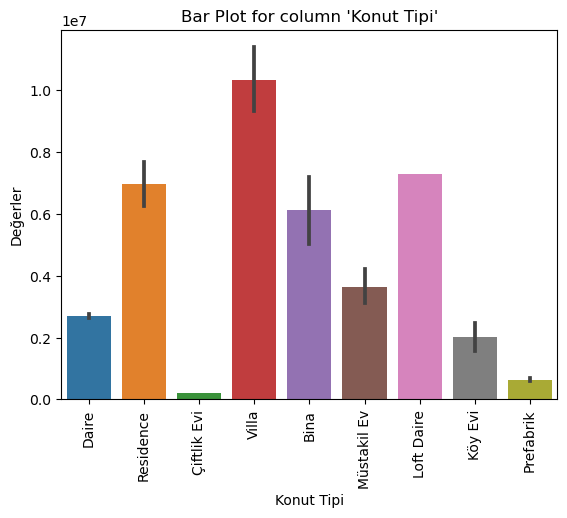

----------------------------------------------
Bar Plot for column 'Mahalle'


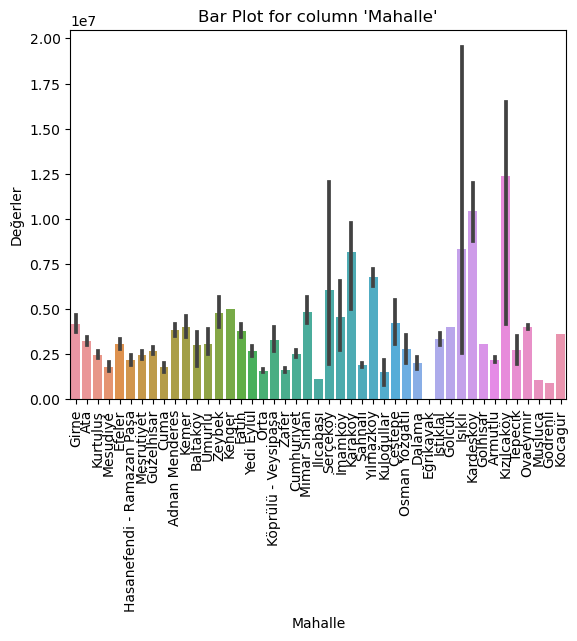

----------------------------------------------
Bar Plot for column 'Isınma Tipi'


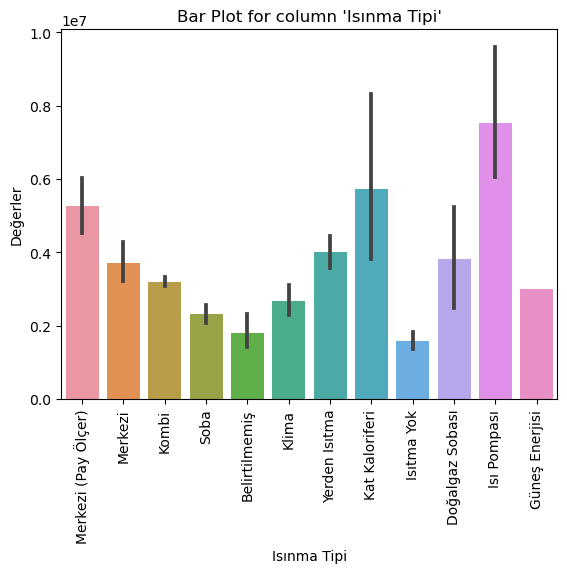

----------------------------------------------
Bar Plot for column 'Cephe'


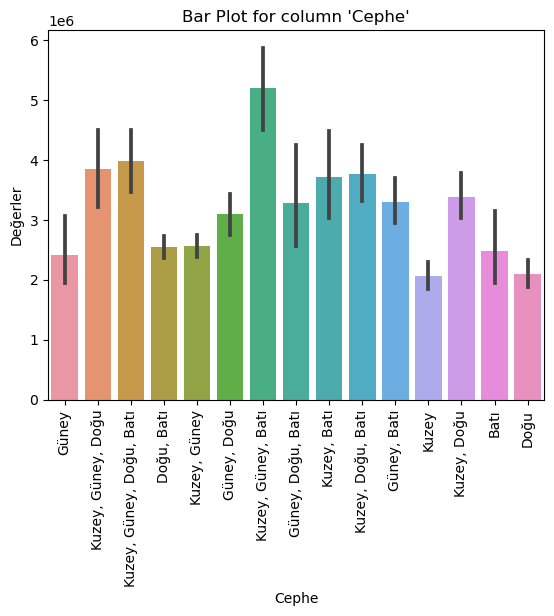

----------------------------------------------
Bar Plot for column 'Kullanım Durumu'


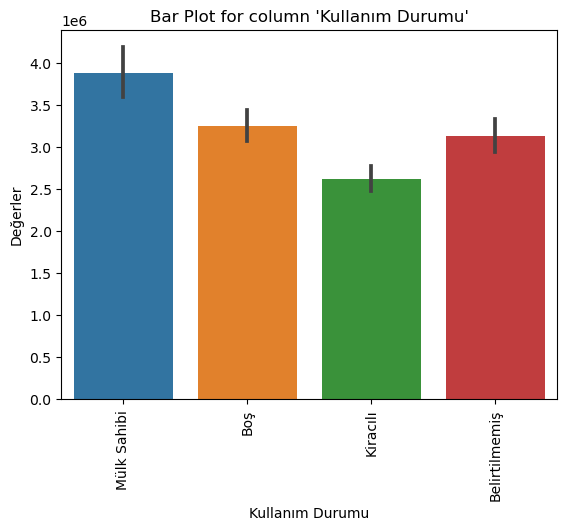

----------------------------------------------
Bar Plot for column 'Yakıt Tipi'


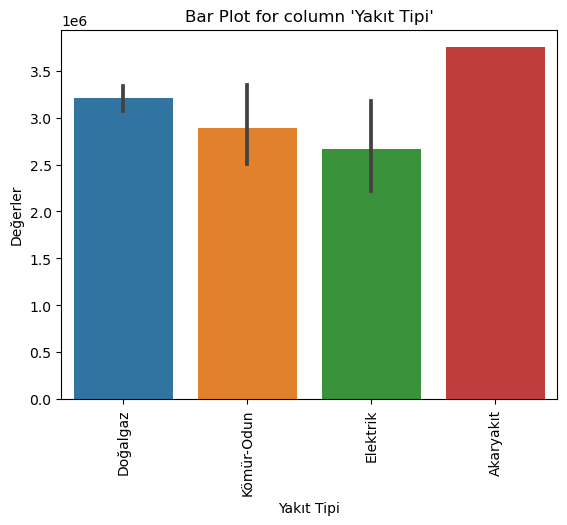

----------------------------------------------


In [20]:
cat_cols = df.select_dtypes(include=['object']).columns
for column in cat_cols:
    print(f"Bar Plot for column '{column}'")
    sns.barplot(x=df[column], y=df["Fiyat"])
    plt.xlabel(column)
    plt.xticks(rotation=90)
    plt.ylabel('Değerler')
    plt.title(f"Bar Plot for column '{column}'")
    plt.show()
    print("----------------------------------------------")

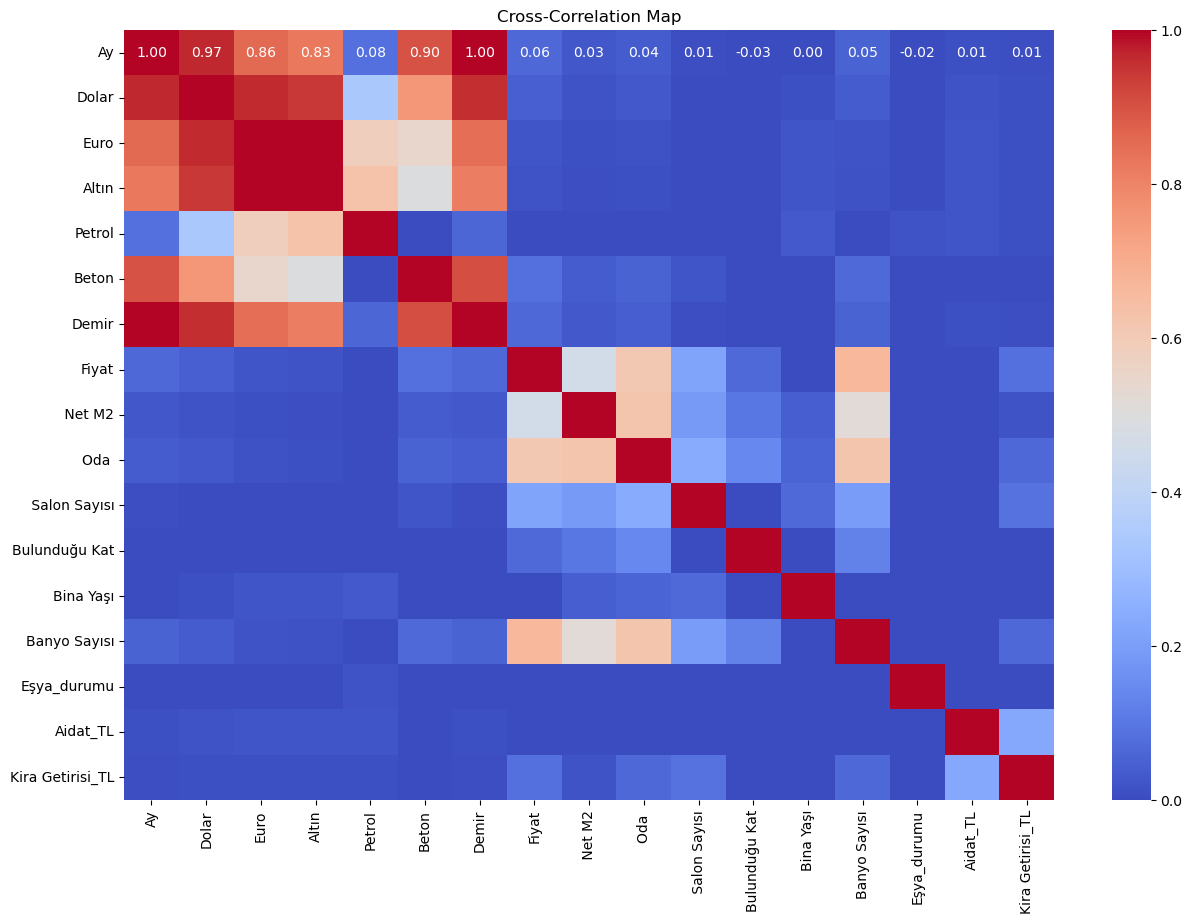

In [21]:
numeric_df = df.select_dtypes(include=['float64', 'int64', "int32"])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=0, vmax=1)
plt.title('Cross-Correlation Map')
plt.show()

In [22]:
df["Yakıt Tipi"].unique()
yakit = {
    "Doğalgaz" : 4,
    "Elektrik" : 3,
    "Akaryakıt": 2,
    "Kömür-Odun": 1
}
df["Yakıt Tipi"] = df["Yakıt Tipi"].map(yakit)

In [23]:
df["Kullanım Durumu"] = df["Kullanım Durumu"].apply(lambda x: 0 if x != 'Boş' else 1)


In [24]:
encoded_df = pd.get_dummies(df["Konut Tipi"], prefix='Konut Tipi')


df_concatenated = pd.concat([df, encoded_df], axis=1)
df_concatenated.drop(columns = [ "Ay","Beton","Konut Tipi"] , inplace = True)

In [ ]:
directions = ["Kuzey", "Güney", "Doğu", "Batı"]

for direction in directions:
    df[direction] = df['Cephe'].apply(lambda x: 1 if direction in x else 0)

In [26]:
df.drop(columns = "Cephe",inplace = True)

In [27]:
# df_concatenated.to_csv("prepared_aydın_house.csv")

In [28]:
import pandas as pd 
data  = pd.read_csv("prepared_aydin_house.csv")
df = data.copy()

In [29]:
df = df.dropna()

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

df = df.dropna()
X , y = df.drop(columns = ["Fiyat","Son Güncelleme Tarihi","Unnamed: 0","Mahalle","Isınma Tipi","Altın","Euro"]) , df["Fiyat"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
print("Random Forest : ")
model_random_forest = RandomForestRegressor(n_estimators=100, min_samples_split=2)
model_random_forest.fit(X_train, y_train)

y_pred = model_random_forest.predict(X_test)

r2 = r2_score(y_test, y_pred)

print("R^2 Score:", r2)

print("Gradient Boosting")
model = GradientBoostingRegressor(n_estimators=80, min_samples_split=2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)


R-squared: 0.6294206963531415
Random Forest : 
R^2 Score: 0.7455746753305854
Gradient Boosting
R^2 Score: 0.7891316430234522


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

df = df.dropna()
X , y = df.drop(columns = ["Fiyat","Son Güncelleme Tarihi","Unnamed: 0","Mahalle","Isınma Tipi","Altın","Euro"]) , df["Fiyat"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("Linear Regression Test R^2 Score:", r2)

y_pred_train = model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
print("Linear Regression Train R^2 Score:", r2_train)
print("-----------------------------")

model_random_forest = RandomForestRegressor(n_estimators=100, min_samples_split=2)
model_random_forest.fit(X_train, y_train)

y_pred_rf = model_random_forest.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest Test R^2 Score:", r2_rf)

y_pred_rf_train = model_random_forest.predict(X_train)
r2_rf_train = r2_score(y_train, y_pred_rf_train)
print("Random Forest Train R^2 Score:", r2_rf_train)
print("-----------------------------")


model_gradient_boosting = GradientBoostingRegressor(n_estimators=80, min_samples_split=2)
model_gradient_boosting.fit(X_train, y_train)

y_pred_gb = model_gradient_boosting.predict(X_test)
r2_gb = r2_score(y_test, y_pred_gb)
print("Gradient Boosting Test R^2 Score:", r2_gb)


y_pred_gb_train = model_gradient_boosting.predict(X_train)
r2_gb_train = r2_score(y_train, y_pred_gb_train)
print("Gradient Boosting Train R^2 Score:", r2_gb_train)


Linear Regression Test R^2 Score: 0.6294206963531415
Linear Regression Train R^2 Score: 0.6863527505849629
-----------------------------
Random Forest Test R^2 Score: 0.7379260290664245
Random Forest Train R^2 Score: 0.9518876388939416
-----------------------------
Gradient Boosting Test R^2 Score: 0.7896703761208637
Gradient Boosting Train R^2 Score: 0.8855869721213909
